In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from time import time
import mpmath as mp
from numba import njit

In [2]:
class VanillaOption():

    def __init__(self, r, S, k, t):
        self.r = r
        self.S = S
        self.k = k
        self.t = t
        
        
class VanillaCall(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(self.S[:,-1] - self.k, 0)*np.exp(-self.r*self.t))
    
    
class VanillaPut(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))

In [3]:
class BSEuroOption():

    def __init__(self, r, q, S, sigma, k, t):
        self.r = r
        self.q = q
        self.S = S
        self.sigma = sigma
        self.k = k
        self.t = t
        self.d1 = ((np.log(self.S / self.k) + (self.r- self.q + np.square(self.sigma) / 2) * self.t)) / (sigma * np.sqrt(self.t))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.t)


class BSCall(BSEuroOption):

    @property
    def price(self):
        # S * N(d1) - K * N(d2)
        return self.S * np.exp(-self.q * self.t) * norm.cdf(self.d1) - self.k * np.exp(-self.r * self.t) * norm.cdf(self.d2)

    @property 
    def delta(self):
        return np.exp(- self.q * self.t) * norm.cdf(self.d1) 

    @property 
    def gamma(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t)) 

    @property 
    def vega(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) * self.S * np.sqrt(self.t)
    
    
class BSPut(BSEuroOption):


    @property
    def price(self):
        return self.k * np.exp(-self.r * self.t) * norm.cdf(-self.d2) - self.S * np.exp(-self.q * self.t) * norm.cdf(-self.d1) 

    @property 
    def delta(self):
        return -1 * np.exp(- self.q * self.t) * norm.cdf(-self.d1)

    @property 
    def gamma(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t)) 

    @property 
    def vega(self):
        return np.exp(- self.q * self.t) * self.S * np.sqrt(self.t) *  norm.pdf(self.d1) / 100
        #return np.exp(- self.q * self.t) * np.sqrt(self.t) *  norm.pdf(self.d1) / 100

In [4]:
def simulate_GBM(sims, T, dt, S0, r, q, sigma):
    m = int(1/(T * dt))
    equity = np.zeros((sims, m+1))
    X = np.random.randn(sims, m)
    equity[:, 1:] = (r-q-sigma*sigma / 2) * dt + sigma * np.sqrt(dt) * X
    return S0 * np.exp(equity.cumsum(axis=1))
    

In [265]:
nsim=100000
timesteps=360
maturity=1
psi=.3877
theta = 0.18*0.18
kappa = 2
V0 = 0.18*0.18
dt = maturity / timesteps
sqrtdt = np.sqrt(dt)
out = np.zeros((nsim, timesteps))

for sim in range(nsim):
    v = V0
    out[sim,0] = v
    for n in range(1,timesteps):
        z = np.random.randn()
        v = v + kappa * (theta - v) * dt + psi * sqrtdt * np.sqrt(v) * z
        if v < 0.0001:
            v = 0.0001
        out[sim,n] += v
out = np.sqrt(out)
print(f'{np.mean(out[:,-1]):.2%}')

15.75%


In [302]:
nsim=100000
timesteps=360
maturity=1
psi=.3877
theta = 0.18*0.18
kappa = 2
V0 = 0.18*0.18
dt = maturity / timesteps
sqrtdt = np.sqrt(dt)
out = np.zeros((timesteps))
out2 = np.zeros((nsim))
for sim in range(nsim):
    v = V0
    out[0] = v
    for n in range(1,timesteps):
        z = np.random.randn()
        v = v + kappa * (theta - v) * dt + psi * sqrtdt * np.sqrt(v) * z
        if v < 0.0001:
            v = 0.0001
        out[n] += v
        if n == timesteps-1:
            out2[sim] = v
out = out / nsim
out = np.sqrt(out)
out2 = np.sqrt(out2)
print(f'{out[-1]:.2%}')
print(f'{np.mean(out2):.2%}')

18.02%
3.25%


In [307]:
np.sqrt(0.0325)

0.18027756377319948

In [305]:
print(f'{np.mean(out2):.2%}')

15.73%


In [212]:
def HESTON_VOL(rvs, nsim=100000, timesteps=360, maturity=1, eta=.3877, theta = 0.18*0.18, kappa = 2, V0 = .18):
    dt = maturity / timesteps
    sqrtdt = np.sqrt(dt)
    V = np.zeros((nsim, timesteps+1))
    V[:,0] = V0*V0
    for j in range(nsim):
        for n in range(timesteps):
            rv = rvs[j,n]
            #V[:,n+1] = (np.maximum(V[:,n] + kappa * (theta - V[:,n]) * dt + 
             #                      eta * np.sqrt(np.maximum(V[:,n],0.0001)) * rv * np.sqrt(dt), 0.0001))
            V[j,n+1] = (abs(V[j,n] + kappa * (theta - V[j,n]) * dt + 
                            eta * np.sqrt(V[j,n]) * rv * sqrtdt))
    Vol = np.sqrt(V)
    return Vol

def simulate_GBMSA(sims, T, dt, S0, V0, r, q, eta, kappa, rho, theta):
    m = int(1/(T * dt))
    equity = np.zeros((sims, m+1))
    X1 = np.random.randn(sims, m)
    X2 = np.random.randn(sims, m)
    X3 = rho * X1 + np.sqrt(1-rho*rho)*X2
    vol = HESTON_VOL(X1, sims, m, T, eta, theta, kappa, V0)
    equity[:, 1:] = (r-q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
    return S0 * np.exp(equity.cumsum(axis=1)), vol

[[ 1.         -0.71875523]
 [-0.71875523  1.        ]]


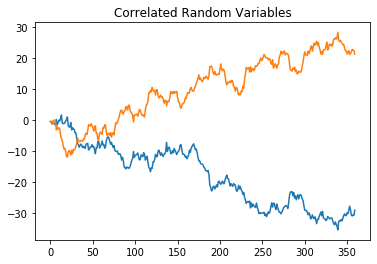

In [175]:
    sims = 10000
    rho = -0.7
    np.random.seed(1234)
    X1 = np.random.randn(sims, 360)
    X2 = np.random.randn(sims, 360)
    X3 = rho * X1 + np.sqrt(1-rho*rho)*X2
    scn = np.random.choice(sims, 1)
    plt.plot(X1[scn[0],:].cumsum(axis=0));
    plt.plot(X3[scn[0],:].cumsum(axis=0));
    plt.title('Correlated Random Variables')
    print(np.corrcoef(X1[scn,:], X3[scn,:]))

In [157]:
scn

array([1564])

Text(0.5, 1.0, 'Correlated Random Variables')

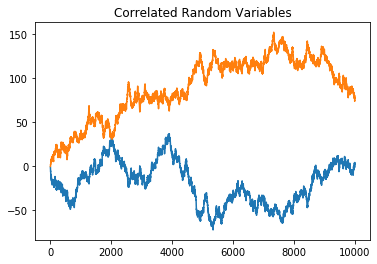

In [142]:
sims = 10000
rho = -0.7
np.random.seed(1234)
rho = -0.7
Ndraws = 10000
mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [6]:
def simulate_VG(sims, T, dt, S0, r, q, sigma, nu, theta):
    m = int(1/(T * dt))
    omega = np.log(1 - theta*nu - sigma*sigma*nu/2)/nu
    equity = np.zeros((sims, m+1))
    drift = r - q + omega
    g = np.random.gamma(dt/nu, nu,(sims,m))
    X = theta*g + sigma*np.sqrt(g)*np.random.randn(sims, m)
    equity[:, 1:] = drift * dt + X
    return S0 * np.exp(equity.cumsum(axis=1))    

In [7]:
def simulate_VGSA(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam):
    m = int(1/(T * dt))
    omega = np.zeros((sims, m+1))
    iu = (1/nu) * np.log(1 - theta*nu - sigma*sigma*nu/2)
    gamma = np.sqrt(kappa*kappa - 2*lam*lam*iu)
    equity = np.zeros((sims, m+1))
    drift = r - q
    g = np.random.gamma(dt/nu, nu,(sims,m))
    X = VGSA_TimeChange(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam)
    jh = np.array([(ii)*dt for ii in range(m+1)], dtype=float)
    omega = np.log(phi(jh, kappa, eta, lam, gamma, iu, nu))
    domega = - np.diff(omega, prepend=0.0)                 
    equity[:, 1:] = drift * dt + domega[:-1].T + X[:,:-1]
    return S0 * np.exp(equity.cumsum(axis=1))  

def A(t, kappa, eta, lam, gamma, iu):
    num = np.exp(kappa*kappa*eta*t/(lam*lam))
    par = np.cosh(gamma*t/2) + (kappa/gamma)*np.sinh(gamma*t/2)
    ex = 2*kappa*eta/(lam*lam)
    return num/(par**ex)

def B(t, kappa, eta, lam, gamma, iu):
    return (2*iu) / (kappa +gamma*np.cosh(gamma*t/2)/np.sinh(gamma*t/2))

def phi(t, kappa, eta, lam, gamma, iu, nu):
    
    return A(t, kappa, eta, lam, gamma, iu)*np.exp(B(t, kappa, eta, lam, gamma, iu)/nu)

def VGSA_TimeChange(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam):
    m = int(1/(T * dt))
    y = np.zeros((sims, m+1))
    X = np.zeros((sims, m+1))
    y[:,0] = 1/nu
    Z1 = np.random.randn(sims, m)
    Z2 = np.random.randn(sims, m)
    for n in range(m):

        y[:,n+1] = (y[:,n] + kappa*(eta - y[:,n])*dt + lam*np.sqrt(y[:,n])*np.sqrt(dt)*Z1[:,n]
                   + (lam*lam)/4 * dt * (Z1[:,n]**2 - 1))
        t_tilda = dt/2 * (y[:,n+1] +y[:,n])
        g = np.random.gamma(t_tilda/nu, nu,sims)
        X[:,n] = theta*g + sigma*np.sqrt(g)*Z2[:,n]     
    return X

In [214]:
st = time()
S2, vol2 = simulate_GBMSA(100000, 1, 1/(360), 100, .18, .02, .01, 0.3877, 2.0, 0, .18**2)
print(f'Elapsted time is {time() - st:.2f} seconds.')

Elapsted time is 110.84 seconds.


In [187]:
import pyodbc

In [365]:
EffectiveDate = "'2021-12-31'"
connstr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=actuarialdata.nwie.net,1021;DATABASE=NFActCorp;Trusted_Connection=yes;'
query = "EXEC [EconData].[Curve_NominalRates_Get] " + EffectiveDate
query2 = "Exec NFActCorp.QRM.SHARED_VOL_SURFACE_PIVOT_GET 'Master'," + EffectiveDate + ", 'SPX'"
rates = []
vol = []
with pyodbc.connect(connstr) as cnxn:

    with cnxn.cursor() as crs:
        crs.execute(query)
        for row in crs:
            actual.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query2)
        for row in crs:
            vol.append(row)

In [254]:
import pyodbc
import pandas as pd

EffectiveDate = "'2021-12-31'"
connstr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=actuarialdata.nwie.net,1021;DATABASE=NFActCorp;Trusted_Connection=yes;'
query = "EXEC [EconData].[Curve_NominalRates_Get] " + EffectiveDate
query2 = "Exec NFActCorp.QRM.SHARED_VOL_SURFACE_PIVOT_GET 'Master'," + EffectiveDate + ", 'SPX'"
cnxn = pyodbc.connect(connstr)
data = pd.read_sql(query2,cnxn)

In [415]:
np.array(vol[:][:][11][3:])

array([0.41363521, 0.36679943, 0.32104491, 0.28016777, 0.23898043,
       0.19574346, 0.15681678, 0.14111536, 0.14667996, 0.15522931,
       0.16101886])

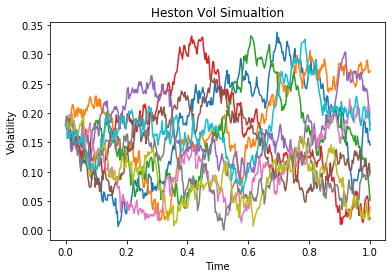

In [276]:
xAxis = np.arange(361)/360
scns = np.random.choice(vol2.shape[0], 10)
for s in range(10):
    plt.plot(xAxis,vol2[scns[s],:])
plt.title('Heston Vol Simualtion')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()

Average Volatility after one year is:  15.78%


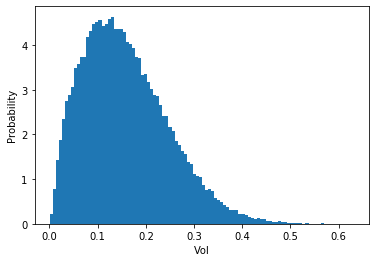

In [220]:
x = vol2[:,-1]
plt.hist(x, density=True, bins=100)  
plt.ylabel('Probability')
plt.xlabel('Vol');
print(f'Average Volatility after one year is:  {np.mean(x):.2%}')

In [272]:
@njit
def HESTON_VOL_njit(rvs, nsim=100000, timesteps=360, maturity=1, psi=.3877, theta = 0.18*0.18, kappa = 2, V0 = .18):
    dt = maturity / timesteps
    V = np.zeros((nsim, timesteps+1))
    V[:,0] = V0*V0
    for n in range(timesteps):
        rv = rvs[:,n]
        V[:,n+1] = (np.maximum(V[:,n] + kappa * (theta - V[:,n]) * dt + 
                               psi * np.sqrt(np.maximum(V[:,n],0.0001)) * rv * np.sqrt(dt), 0.0001))
    Vol = np.sqrt(V)
    return Vol


def simulate_GBMSA_njit(sims, T, dt, S0, V0, r, q, psi, kappa, rho, theta):
    m = int(1/(T * dt))
    equity = np.zeros((sims, m+1))
    X1 = np.random.randn(sims, m)
    X2 = np.random.randn(sims, m)
    X3 = rho * X1 + np.sqrt(1-rho*rho)*X2
    vol = HESTON_VOL_njit(X1, sims, m, T, psi, theta, kappa, V0)
    equity[:, 1:] = (r-q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
    return S0 * np.exp(equity.cumsum(axis=1))

In [23]:
st = time()
S2_njit = simulate_GBMSA_njit(1000000, 1, 1/360, 100, .18, .02, .01, 0.3877, 2.0, -0.70, .18**2)
print(f'Elapsted time is {time() - st:.2f} seconds.')

Elapsted time is 54.96 seconds.


In [ ]:
S1 = simulate_GBM(1000, 1, 1/360, 100, .02, .01, 0.18)
S2 = simulate_GBMSA(1000, 1, 1/360, 100, .18, .02, .01, 0.3877, 2.0, -0.70, .18**2)
S3 = simulate_VG(1000, 1, 1/360, 100, .02, .01, 0.18, 0.18, -.01)
S4 = simulate_VGSA(1000, 1, 1/360, 100, .02, .01, 0.18, 0.18, -.01, 1.0, 1/.18, .2)

In [81]:
def EuroPricer(strike, discount, optiontype, equity):
    if optiontype == 'C':
        Price = np.mean(np.maximum(equity[:,-1] - strike, 0)*np.exp(-discount))
    else:
        Price = np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))
    return Price

In [314]:
r = .04
q = .02
s0 = 100
sigma = .2
psi = 0.3877
kappa = 2.0
rho = 0
theta = .213
k = 100
T = 1
dt = 1/(360*2)
sims = 100000
c = BSCall(r, q, s0, sigma, k, T)
np.random.seed(1234)
S1 = simulate_GBM(sims, T, dt, s0, r, q, sigma)
c1 = EuroPricer(k, r*T, 'C', S1)
np.random.seed(1234)
S2 = simulate_GBMSA_njit(sims, T, dt, s0, sigma, r, q, psi, kappa, rho, theta**2)
c2 = EuroPricer(k, r*T, 'C', S2)
print(f'Black-Scholes Price: ${c.price:.2f}')
print(f'GBM Price: ${c1:.2f}')
print(f'GBMSA Price: ${c2:.2f}')

Black-Scholes Price: $8.74
GBM Price: $8.73
GBMSA Price: $8.73


In [400]:
from abc import ABC, abstractmethod
from typing import Tuple, List, Sequence, Dict, Union
from scipy.optimize import minimize, OptimizeResult 
from scipy.optimize import Bounds
from random import seed
from scipy.optimize import least_squares

class OptionPricingModel(ABC):
    """
    Model that can be used to price Euoprean Vanilla Options.
    """
    
    def __init__(self):
        self._parameters = None
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters

    
    @parameters.setter
    @abstractmethod
    def parameters(self, value: Sequence[float]):
        """
        The model parameters, returned as a list of real numbers.
        """
        pass
        
    
    @abstractmethod
    def simulate(self):
        pass   
        
        
    def calibrate(self, real_prices, clsOption, strikes, maturities, weight: np.array=None):
        if weight is None:
            weight = np.ones(real_prices.shape)
        dt = 1/360
        sims = 10000
        simlen = max(maturities)
        cols = (maturities / dt + 1).astype(int)
        loss = self.get_loss_function(real_prices, weight, clsOption, strikes, maturities, sims, simlen, cols, dt)
        res = minimize(loss, self.parameters, options=self.options)
        self.parameters = res.x
        return res, self
        
    def get_loss_function(self, real_prices, weight, clsOption, strikes, maturities, sims, simlen, cols, dt):    

        def _loss_function(parameters):
            np.random.seed(1234)
            self.paramters = parameters
            S = self.simulate(sims, simlen, dt)
            predicted = []
            for i in range(len(strikes)):
                predicted.append(clsOption(self.r, S[:,:cols[i]], self.s0*strikes[i], maturities[i]).price)
            return sum(weight*(real_prices - np.array(predicted, dtype=float))**2)
        return _loss_function
    

In [401]:
class GBMSA(OptionPricingModel):
    
    def __init__(self, s0, v0, r, q, psi, kappa, rho, theta):
        super().__init__()
        self.r = r
        self.q = q
        self.s0 = s0
        self.v0 = v0
        self.psi = psi
        self.kappa = kappa
        self.rho = rho
        self.theta = theta
        self.bounds = ([0, 0, -1.0, 0],[1.0, 10.0, 1.0, 1.0])
        self.options = {'gtol': 1e-6, 'disp': True}
        self.parameters = (self.psi, self.kappa, self.rho, self.theta)
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        if value is not None:
            self.psi = value[0]
            self.kappa = value[1]
            self.rho = value[2]
            self.theta = value[3]
            self._parameters = value

            
    def HESTON_VOL(self,rvs, nsim=100000, timesteps=360, maturity=1, psi=.3877, theta = 0.18*0.18, kappa = 2, v0 = .18):
        dt = maturity / timesteps
        v = np.zeros((nsim, timesteps+1))
        v[:,0] = v0*v0
        for n in range(timesteps):
            rv = rvs[:,n]
            v[:,n+1] = np.maximum(v[:,n] + kappa * (theta - v[:,n]) * dt + 
                                   psi * np.sqrt(v[:,n]) * rv * np.sqrt(dt),0.0001)
                
        vol = np.sqrt(v)
        return vol

    def simulate(self, sims, T, dt):
        m = int(1/(T * dt))
        equity = np.zeros((sims, m+1))
        X1 = np.random.randn(sims, m)
        X2 = np.random.randn(sims, m)
        X3 = self.rho * X1 + np.sqrt(1-self.rho*self.rho)*X2
        vol = self.HESTON_VOL(X1, sims, m, T, self.psi, self.theta, self.kappa, self.v0)
        equity[:, 1:] = (self.r-self.q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
        return self.s0 * np.exp(equity.cumsum(axis=1))

In [371]:
st = time()
r = .04
q = .02
s0 = 100
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.90, 1.00, 1.10, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,])
iVols = np.array([0.4136352076, 0.3667994289, 0.3210449054, 0.2801677723, 0.2389804271, 0.1957434566, 0.1568167792, 0.1411153595, 0.1466799576, 0.155229309, 0.1610188562])
options = []
for i in range(len(iVols)):
    options.append(BSCall(r, q, s0, iVols[i], s0*strikes[i], maturities[i]))
real_prices = np.array([o.price for o in options])
print(real_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')

[50.46193451 41.27208778 32.29574518 23.73097326 15.72081812  8.5763353
  3.25038525  0.92959338  0.3323991   0.13600996  0.05288513]
Elapsted time is 0.00 seconds.


In [405]:
st = time()
v0 = .18
psi = .3
kappa = 2.0
rho = -0.75
theta = .23**2
k = 100
T = 1
dt = 1/360
sims = 100000
model = GBMSA(s0, v0, r, q, psi, kappa, rho, theta)
S = model.simulate(sims, 1, 1/360)
h_options = []
for s in range(len(strikes)):
    h_options.append(VanillaCall(r, S, strikes[s]*100,1))
h_prices = np.array([o.price for o in h_options])
print(h_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((h_prices - real_prices)**2)

[5.00158799e+01 4.05473863e+01 3.13477684e+01 2.27072791e+01
 1.50602357e+01 8.86445859e+00 4.46163108e+00 1.84693899e+00
 6.12333353e-01 1.61941650e-01 3.53412647e-02]
Elapsted time is 5.12 seconds.


5.578133598769071

In [406]:
st = time()
model.calibrate(real_prices, VanillaCall, strikes, maturities)
print(f'Elapsted time is {time() - st:.2f} seconds.')

Optimization terminated successfully.
         Current function value: 4.468894
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1
Elapsted time is 2.48 seconds.


In [407]:
st = time()
S = model.simulate(sims, 1, 1/360)
h_options = []
for s in range(len(strikes)):
    h_options.append(VanillaCall(r, S, strikes[s]*100,1))
h_prices = np.array([o.price for o in h_options])
print(h_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((h_prices - real_prices)**2)

[4.99554142e+01 4.04909575e+01 3.12959936e+01 2.26704790e+01
 1.50437155e+01 8.87109403e+00 4.47755630e+00 1.85744947e+00
 6.11273454e-01 1.58981500e-01 3.43832731e-02]
Elapsted time is 5.05 seconds.


5.981736045104063

In [412]:
np.sqrt(model.parameters[3])

0.23

In [72]:
def RebateBufferPricer(buffer, discount, rebate, equity):
    k = (1-buffer)*equity[:,0]
    rebate = rebate * equity[:,0]
    Price = np.mean(((equity[:,-1] >= k)*rebate - np.maximum(k - equity[:,-1], 0))*np.exp(-discount))

    return Price

In [74]:
buffer = .10
rebate = .10


print(f'The Price of a {rebate:.0%} coupon with a {buffer:.0%} buffer option is ${RebateBufferPricer(buffer,r,rebate,S):.2f}.')

The Price of a 10% coupon with a 10% buffer option is $2.76.


In [118]:
S1 = simulate_GBM(100000, 1, 1/360, 100, .02, .01, 0.18)
S2, vol2 = simulate_GBMSA(100000, 1, 1/360, 100, .18, .02, .01, 0.3877, 2.0, -0.70, .18**2)

In [119]:
buffer = .10
rebate = .10


print(f'The Price of a {rebate:.0%} coupon with a {buffer:.0%} buffer option is ${RebateBufferPricer(buffer,r,rebate,S1):.2f}.')
print(f'The Price of a {rebate:.0%} coupon with a {buffer:.0%} buffer option is ${RebateBufferPricer(buffer,r,rebate,S2):.2f}.')

The Price of a 10% coupon with a 10% buffer option is $4.21.
The Price of a 10% coupon with a 10% buffer option is $4.43.


In [234]:
r = .04
q = .02
s0 = 100
sigma = .2
k = 100
T = 1
dt = 1/(360*2)
sims = 100000
c = BSCall(r, q, s0, sigma, k, T)
S3 = simulate_VG(100000, 1, dt, s0, r, q, 0.2, 0.4, .1)
c3 = EuroPricer(k, r*T, 'C', S3)
print(f'Black-Scholes Price: ${c.price:.2f}')
print(f'VG Price: ${c3:.2f}')

Black-Scholes Price: $8.74
VG Price: $8.85


In [ ]:
def simulate_VG(sims, T, dt, S0, r, q, sigma, nu, theta):
    m = int(1/(T * dt))
    omega = np.log(1 - theta*nu - sigma*sigma*nu/2)/nu
    equity = np.zeros((sims, m+1))
    drift = r - q + omega
    g = np.random.gamma(dt/nu, nu,(sims,m))
    X = theta*g + sigma*np.sqrt(g)*np.random.randn(sims, m)
    equity[:, 1:] = drift * dt + X
    return S0 * np.exp(equity.cumsum(axis=1))    

In [33]:
class VG(OptionPricingModel):
    
    def __init__(self, s0, v0, r, q, sigma, nu, theta):
        super().__init__()
        self.r = r
        self.q = q
        self.s0 = s0
        self.v0 = v0
        self.sigma = sigma        
        self.nu = nu
        self.theta = theta
        self.bounds = Bounds([0.001, 0.001, -1.0, 0.001], [1.0, 10.0, 1.0, 1.0])
        self.options = {'disp': True}
        self.parameters = (self.sigma, self.nu, self.theta)
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        if value is not None:
            self.sigma = value[0]
            self.nu = value[1]
            self.theta = value[2]
            self._parameters = value


    def simulate(self, sims, T, dt):
        m = int(1/(T * dt))
        omega = np.log(1 - theta*nu - sigma*sigma*nu/2)/nu
        equity = np.zeros((sims, m+1))
        drift = r - q + omega
        g = np.random.gamma(dt/nu, nu,(sims,m))
        X = theta*g + sigma*np.sqrt(g)*np.random.randn(sims, m)
        equity[:, 1:] = drift * dt + X
        return S0 * np.exp(equity.cumsum(axis=1))   

In [375]:
import numpy as np
# Parallel computation using numba
from numba import jit, njit, prange 
from numba import cuda
i = complex(0,1)
# To be used in the Heston pricer
@jit
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):
    # To be used a lot
    prod = rho * sigma *i *s 
    
    # Calculate d
    d1 = (prod - kappa)**2
    d2 = (sigma**2) * (i*s + s**2)
    d = np.sqrt(d1 + d2)
    
    # Calculate g
    g1 = kappa - prod - d
    g2 = kappa - prod + d
    g = g1/g2
    
    # Calculate first exponential
    exp1 = np.exp(np.log(St) * i *s) * np.exp(i * s* r* T)
    exp2 = 1 - g * np.exp(-d *T)
    exp3 = 1- g
    mainExp1 = exp1*np.power(exp2/exp3, -2*theta*kappa/(sigma **2))
    
    # Calculate second exponential
    exp4 = theta * kappa * T/(sigma **2)
    exp5 = volvol/(sigma **2)
    exp6 = (1 - np.exp(-d * T))/(1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 *g1 * exp6))
    
    return (mainExp1 * mainExp2)
# Heston Pricer (allow for parallel processing with numba)
@jit(forceobj=True)
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # Calculate the complex integral
    # Using j instead of i to avoid confusion
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        
        numerator1 = fHeston(s2,  St, K, r, T, 
                             sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, 
                              sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) *i *s1
        
        P = P + ds *(numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

In [438]:
priceHestonMid(100, 100, .04, 1, .2*.2, 1.0, .2*.2, 0, 0)

7.102183187980466